In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [3]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [4]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [6]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [7]:
#Building the category dictionaries
category_lines = {}
all_categories = []

In [8]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [9]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

In [10]:
import torch

In [11]:
#Find letter index from all_letters list
def letterToIndex(letter):
    return all_letters.find(letter)

In [12]:
def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)
    tensor[0][letterToIndex(letter)]=1
    return tensor

In [13]:
def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [14]:
print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


In [15]:
print(lineToTensor('Jones')[0][0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])


In [16]:
import torch.nn as nn

In [19]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        #Python superclass constructors/initialisers for RNN modules (not in automatic)
        super(RNN,self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self,input,hidden):
        combined = torch.cat((input,hidden),1)
        hidden =  self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [20]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

In [25]:
output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9051, -2.7903, -2.8293, -2.8769, -2.9823, -2.8152, -2.9136, -2.9546,
         -2.9858, -3.0043, -2.9433, -2.8644, -2.8530, -2.9097, -2.9049, -2.7395,
         -2.8491, -2.9497]], grad_fn=<LogSoftmaxBackward>)


In [27]:
#Funcion para obtener posible tipo de nombre
def categoryFromOutput(output):
    #Get the index with greatest value
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))    

('Scottish', 15)


In [33]:
import random

def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
    
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, '/ line =', line)
    

category =  Dutch / line = Richard
category =  Spanish / line = Sierra
category =  Vietnamese / line = Mai
category =  Dutch / line = Lauwens
category =  Japanese / line = Nogi
category =  Dutch / line = Kloet
category =  Spanish / line = Belmonte
category =  Dutch / line = Sanna
category =  Korean / line = Sung
category =  Greek / line = Gavril


In [30]:
##VAMOS A ENTRENAR EL MODELO!!
##lET'S TRAIN THE MODEL!!

In [37]:
learning_rate = 0.005
criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        #En este paso el hidden state alimenta nuevamente a la RNN
        output, hidden = rnn(line_tensor[i],hidden)
        
    loss = criterion(output, category_tensor)
    #Backward prop.
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item()

In [38]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    #Imprimir el no. de iteracion, loss, Y_real y Y_estimada
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category 
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.8773 Kranz / Vietnamese ✗ (Dutch)
10000 10% (0m 12s) 3.1976 Kyubei / Italian ✗ (Japanese)
15000 15% (0m 18s) 2.3391 Christie / Greek ✗ (Scottish)
20000 20% (0m 24s) 3.0295 Holguin / Irish ✗ (Spanish)
25000 25% (0m 31s) 0.2838 Sardelis / Greek ✓
30000 30% (0m 38s) 1.4150 Paquet / French ✓
35000 35% (0m 46s) 2.9061 Asker / German ✗ (Arabic)
40000 40% (0m 53s) 3.2309 Alexander / Russian ✗ (Scottish)
45000 45% (1m 0s) 2.6901 Koning / German ✗ (Dutch)
50000 50% (1m 8s) 2.0815 Marek / Czech ✗ (Polish)
55000 55% (1m 15s) 1.9965 Wright / German ✗ (Scottish)
60000 60% (1m 22s) 0.6686 Bao / Chinese ✓
65000 65% (1m 29s) 4.1554 Hassani / Italian ✗ (English)
70000 70% (1m 36s) 0.2332 Zherikhin / Russian ✓
75000 75% (1m 43s) 1.6728 Mclaren / German ✗ (English)
80000 80% (1m 51s) 2.7277 Victor / French ✗ (Czech)
85000 85% (1m 58s) 1.2511 Damhan / Scottish ✗ (Irish)
90000 90% (2m 5s) 0.2931 Banh / Vietnamese ✓
95000 95% (2m 13s) 0.2414 Majewski / Polish ✓
100000 100% (2m 20s) 1.7353 

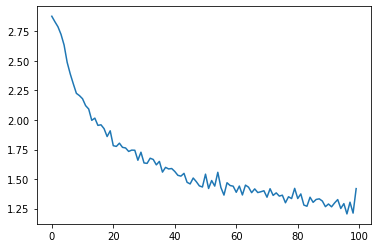

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [50]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    #Evitamos modificar los pesos de nuestro modelo
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Cortez')


> Cortez
(-0.29) Spanish
(-2.21) Polish
(-3.29) Czech
